# Question 2
### Working with ADQL

In [1]:
# Basic imports
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table

In [2]:
# Download the GAIA Data
from astroquery.gaia import Gaia

From the Gaia/2MASS Tables, we need:
- Gaia BP-RP
- Gaia absolute g
- 2Mass J-Ks
- 2Mass Apparent H

In [3]:
# Select relevant columns and join with the 2Mass table. Constrain ra/dec to
# a 1 degree circle from Ruprecht 147
query = """
SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.phot_g_mean_mag, 
gaia.bp_rp, tmass.j_m, tmass.ks_m, tmass.h_m, tmass.ph_qual
FROM gaiadr3.gaia_source AS gaia
JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
JOIN gaiadr1.tmass_original_valid AS tmass ON
   xjoin.original_psc_source_id = tmass.designation
WHERE phot_g_mean_mag < 14
   AND CONTAINS(
     POINT('ICRS', gaia.ra, gaia.dec),
     CIRCLE('ICRS', 289.074, -16.323, 1.0)
   ) = 1;
"""
job = Gaia.launch_job_async(query)
result = job.get_results()
df = result.to_pandas()
display(df.head())
print("Dataframe has shape", df.shape)


INFO: Query finished. [astroquery.utils.tap.core]


,source_id,ra,dec,parallax,phot_g_mean_mag,bp_rp,j_m,ks_m,h_m,ph_qual
0,4088892600474423808,288.225913,-15.744217,0.624552,11.983528,1.559996,10.017,9.218,9.410,AAA
1,4088893154546972672,288.271283,-15.709582,0.454480,12.048648,1.703223,9.941,9.005,9.188,AAA
2,4088893188906716032,288.254396,-15.713978,0.211160,12.808913,1.847858,10.526,9.503,9.733,AAA
3,4087815667506086656,288.512276,-16.874361,0.092825,12.800300,1.850592,10.501,9.492,9.710,AAA
4,4087815697559746304,288.520970,-16.874898,0.366892,11.617373,3.226758,8.277,7.032,7.314,AAA


Dataframe has shape (3637, 10)


In [4]:
# Manipulate column names to be easier to work with, and add absolute g magnitude
# Add an if statement to avoid errors when re-running this cell
if len(df.columns) == 10:
    df.columns = ["ID", "RA", "DEC", "parallax", "g_m", "bp_rp", "j_m", "ks_m", "h_m", "quality"]
    df["g_M"] = df["g_m"]+5*np.log10(df["parallax"]/1000)+5
    df["j_ks"] = df["j_m"] - df["ks_m"]
display(df.head())

c:\Users\taase\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,ID,RA,DEC,parallax,g_m,bp_rp,j_m,ks_m,h_m,quality,g_M,j_ks
0,4088892600474423808,288.225913,-15.744217,0.624552,11.983528,1.559996,10.017,9.218,9.410,AAA,0.961373,0.799000
1,4088893154546972672,288.271283,-15.709582,0.454480,12.048648,1.703223,9.941,9.005,9.188,AAA,0.336221,0.936000
2,4088893188906716032,288.254396,-15.713978,0.211160,12.808913,1.847858,10.526,9.503,9.733,AAA,-0.568030,1.023000
3,4087815667506086656,288.512276,-16.874361,0.092825,12.800300,1.850592,10.501,9.492,9.710,AAA,-2.361372,1.009001
4,4087815697559746304,288.520970,-16.874898,0.366892,11.617373,3.226758,8.277,7.032,7.314,AAA,-0.559937,1.245000


The error in the log10 function here comes from stars with a non-positive parallax. 

From the shape of the dataframe, we can see that the original query yields **3,637 stars**

To see the stars with a poor quality or bad parallax, we can do a selection slice on the relevant column:

In [5]:
df_lowqual = df[df["quality"] != "AAA"]
print(df_lowqual.shape)
df_bad_parallax = df[(df["parallax"] < 0) | (np.isnan(df["parallax"]))]
print(df_bad_parallax.shape)

(79, 12)
(23, 12)


From the quality cuts, we can see **79 stars** have a low 2Mass photometric quality and **23 stars** have a non-positive or NaN parallax

In [6]:
df_good = df[(df["quality"] == "AAA") & (df["parallax"] > 0)]
print(df_good.shape)

(3535, 12)


After the quality cuts, there are **3535 stars** in total

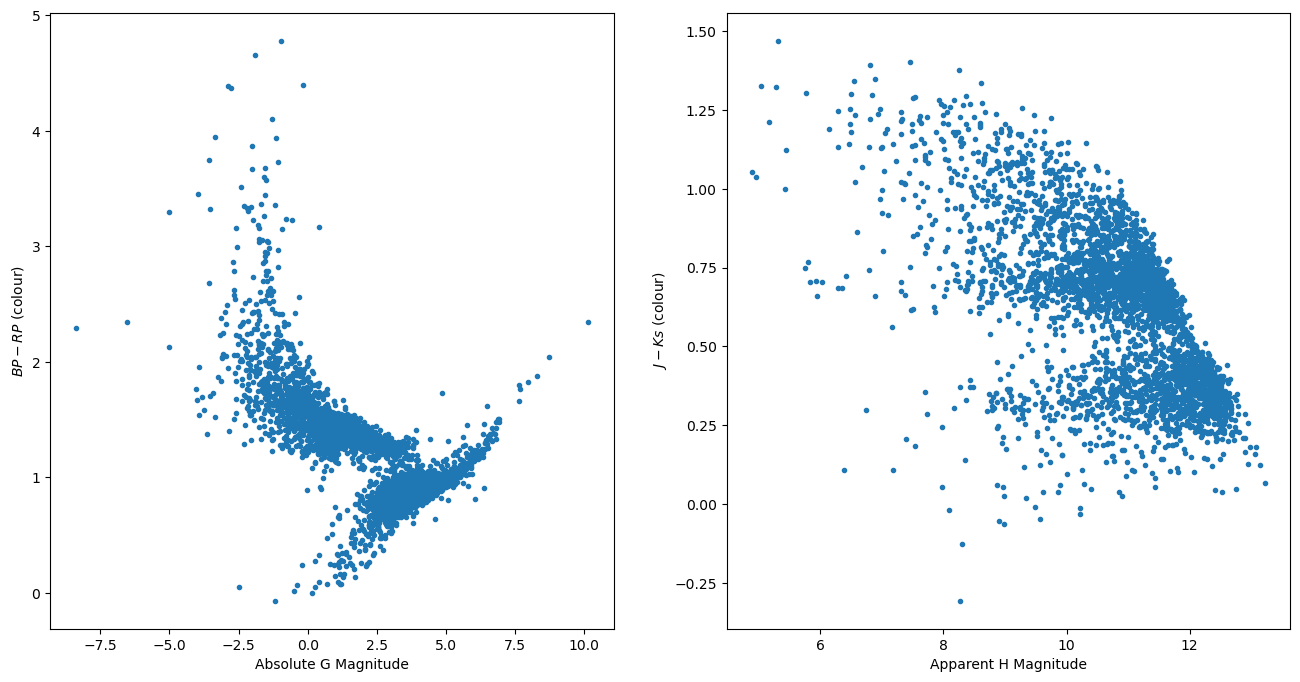

In [7]:
fig, axs = plt.subplots(1,2, figsize=(16, 8))
axl = axs[0]
axr = axs[1]
axl.scatter(df_good["g_M"], df_good["bp_rp"], marker=".")
axl.set_xlabel("Absolute G Magnitude")
axl.set_ylabel("$BP - RP$ (colour)")

axr.scatter(df_good["h_m"], df_good["j_ks"], marker=".")
axr.set_xlabel("Apparent H Magnitude")
axr.set_ylabel("$J-Ks$ (colour)")

plt.savefig("figures/cmds_R147.png", dpi=200, bbox_inches="tight")
plt.show()

In [8]:
print("H < 12.2:", np.sum(df_good["h_m"] < 12.2))
# 3147 stars with H<12.2 and 392 2dF fibres at a time
print(3147/392)
print(3147%392)

H < 12.2: 3147
8.028061224489797
11


There are **3,535** stars to observe and of those stars **3,137** are bright enough ($H<12.2$) to observe with APOGEE (https://www.sdss.org/instruments/apogee-spectrographs/). There are 392 2dF fibers available at any one time (https://aat.anu.edu.au/science/instruments/current/AAOmega). Assuming no fibers are used on things like sky frames, surveying every bright enough star will require **8 full uses of the fibre with 11 stars remaining.** Surveying just these 11 stars with 2dF would be a waste of fiber use, so it would be worth removing 11 stars from the list of stars to observe. If there is no science basis to ignore any particular stars, cutting down the 11 most dim stars in the H-band would be best for the proposal. 